# Object Segmentation with SAM GUI

## Instructions:

Ctrl + left click = run cell  
Shift + left click = run cell and go to the next cell

## Set-up

Download the [model checkpoint](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth) and put it in `checkpoints` folder.

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import SAM
from utils import *

# image path
image_path = r'imgs/img1.png'

# model parameters
sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"


## Loading image

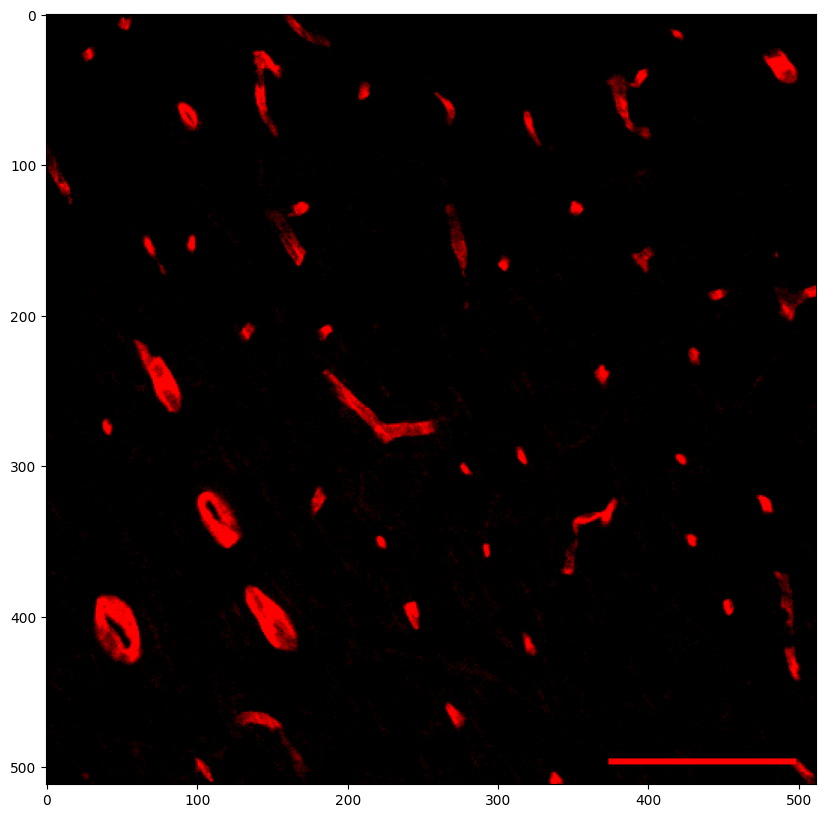

In [3]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = adjust_histogram_gui(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Load and prepare the model

In [4]:
predictor = SAM()
predictor.set_image(image)

## OPTION I: Segmenting objects by clicking multiple points

The model can be used to segment the objects by selecting points as foreground and background.

To select the objects:

Left click = object (green dot)  
Right click = background (red dot)

Mouse scroll down = zoom in  
Mouse scroll up = zoom out

q = quit

*Note 1: Multiple points can be input.*  
*Note 2: The chosen points will be shown as stars on the image.*

In [6]:
points, _, labels = annotate_image_gui(image)
input_point = np.array(points)
input_label = np.array(labels)

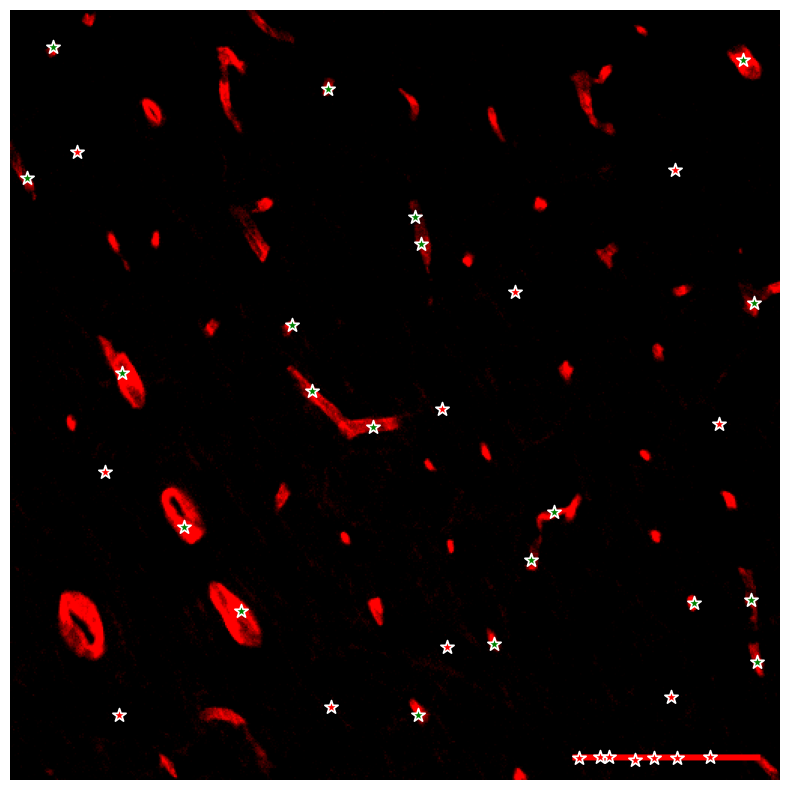

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

## Predict

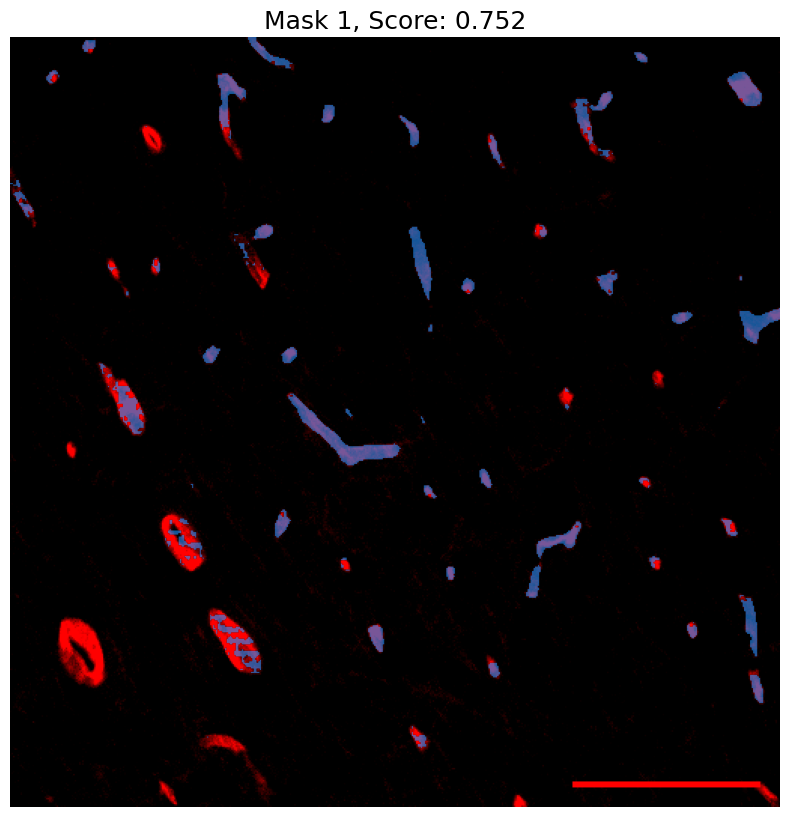

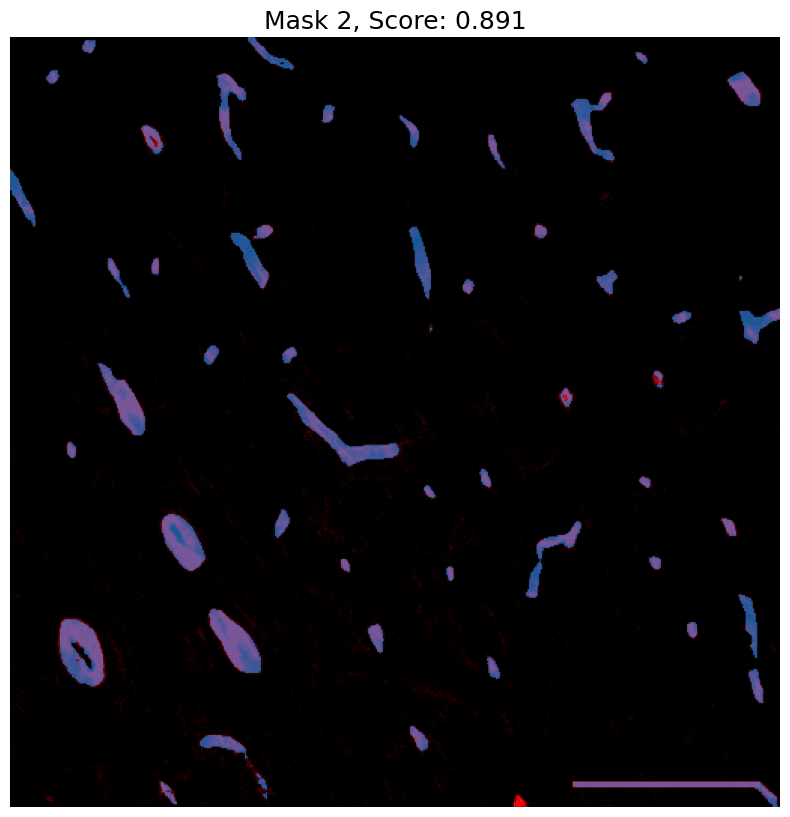

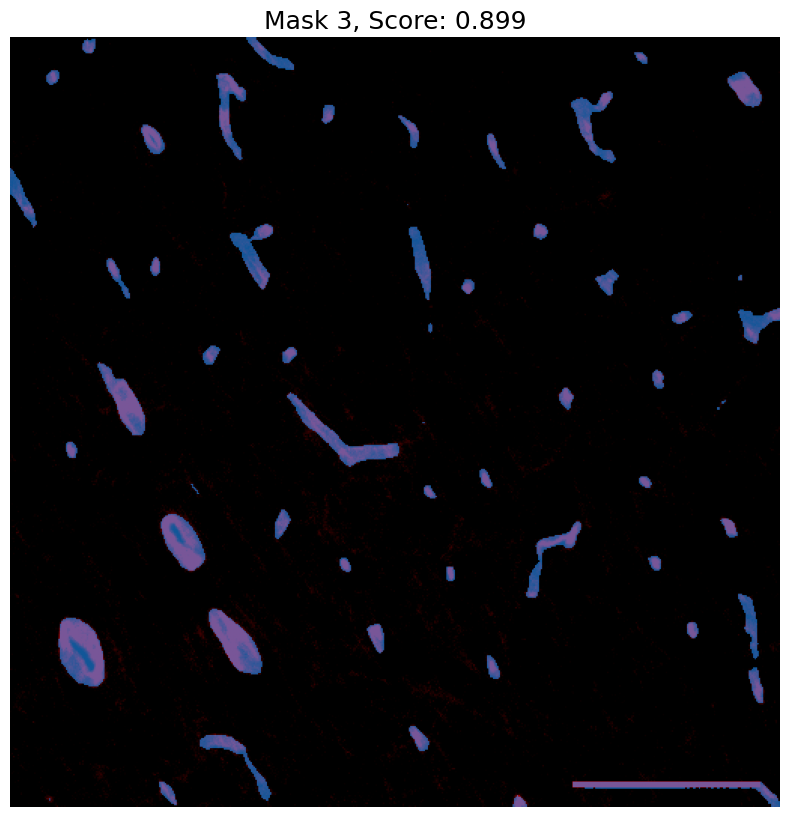

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = np.array((0, 0, image.shape[1], image.shape[0])),
    multimask_output=True)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## Save mask

In [9]:
# save mask
best_mask = 3

input_name = os.path.splitext(image_path)[0]
output_name = input_name + '_mask' + os.path.splitext(image_path)[1]
cv2.imwrite(output_name, np.array(masks[best_mask -1, ...]*255, dtype=np.uint8))

print('mask saved as: {}'.format(output_name))

mask saved as: imgs/img1_mask.png


## OPTION I-A: Updating existing mask with additional points

Mayble, the points were not enough, and the model has returned multiple objects consistent with it. Select the best mask from the previous step and add new points to update the previous mask.

In [10]:
best_mask = 3

In [11]:
points, _, labels = annotate_image_gui(image)
input_point = np.array(points)
input_label = np.array(labels)

# if re-iterating from option I-A
if logits.shape[0] == 1:
    best_mask = 1

mask_input = logits[best_mask - 1, :, :]  # Choose the model's best mask

In [12]:
masks, _, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

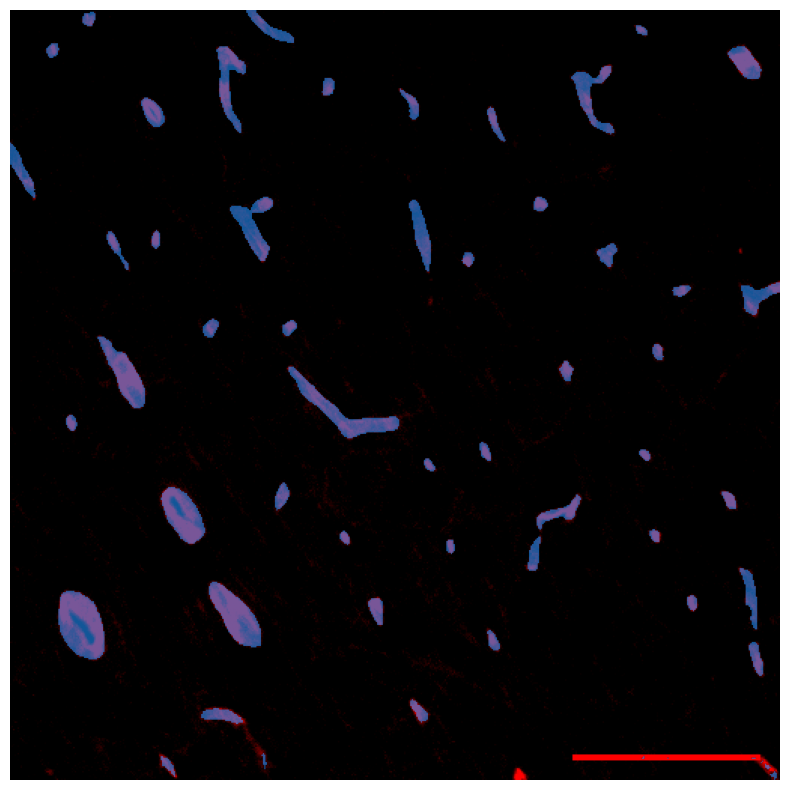

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Save mask

In [14]:
# save image
input_name = os.path.splitext(image_path)[0]
output_name = input_name + '_mask' + os.path.splitext(image_path)[1]
cv2.imwrite(output_name, np.array(masks[0, ...]*255, dtype=np.uint8))

print('mask saved as: {}'.format(output_name))

mask saved as: imgs/img1_mask.png


## OPTION II: Specifying a specific object with a box

The model can take a box as input, and provide the mask inside the box.

1. Switch to box mode : b
2. Draw a box around the object

In [15]:
_, boxes, _ = annotate_image_gui(image)
input_box = np.array(boxes)[0, ...]
input_label = np.array([1])

Switched to box annotation mode


In [16]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)

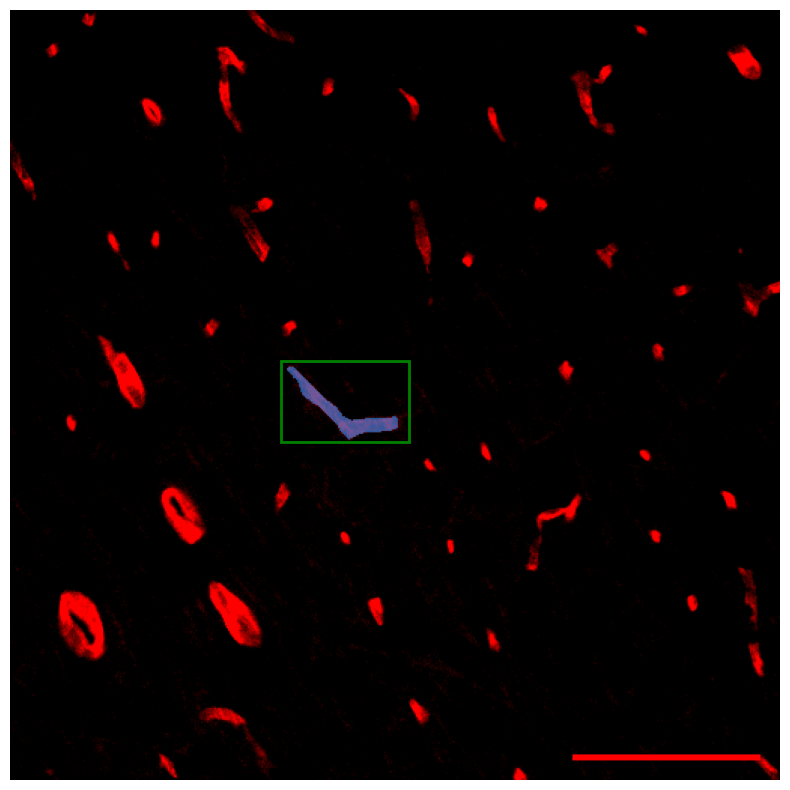

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Save mask

In [18]:
# save mask
input_name = os.path.splitext(image_path)[0]
output_name = input_name + '_mask' + os.path.splitext(image_path)[1]
cv2.imwrite(output_name, np.array(masks[0, ...]*255, dtype=np.uint8))

print('mask saved as: {}'.format(output_name))

mask saved as: imgs/img1_mask.png


## OPTION III: Finding objects in an ROI

You can find objects in an ROI inside the image.

1. Switch to box mode: b
2. Draw one box to delineate the ROI.
3. switch to point mode: p
4. draw points on the image inside the ROI to specify foreground (left click) and background (right click)

In [19]:
points, boxex, labels = annotate_image_gui(image)
input_point = np.array(points)
input_label = np.array(labels)
input_box = np.array(boxex)[0, ...]

Switched to box annotation mode
Switched to point annotation mode


In [20]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

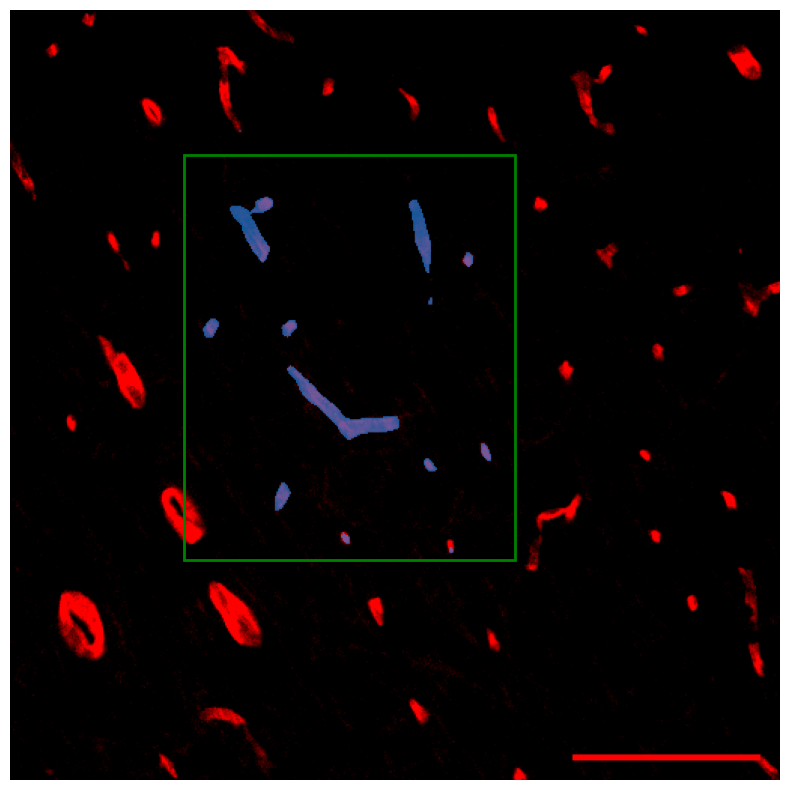

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Save mask

In [22]:
# save mask
input_name = os.path.splitext(image_path)[0]
output_name = input_name + '_mask' + os.path.splitext(image_path)[1]
cv2.imwrite(output_name, np.array(masks[0, ...]*255, dtype=np.uint8))

print('mask saved as: {}'.format(output_name))

mask saved as: imgs/img1_mask.png


## OPTION IV: Instance Segmentation

You can find objects as unique instances.

1. Switch to box mode (keyboard shortcut b)
2. Draw bounding boxes for each object

In [23]:
_, boxes, _ = annotate_image_gui(image)
input_boxes = torch.tensor(boxes, device=predictor.device)

Switched to box annotation mode


In [24]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

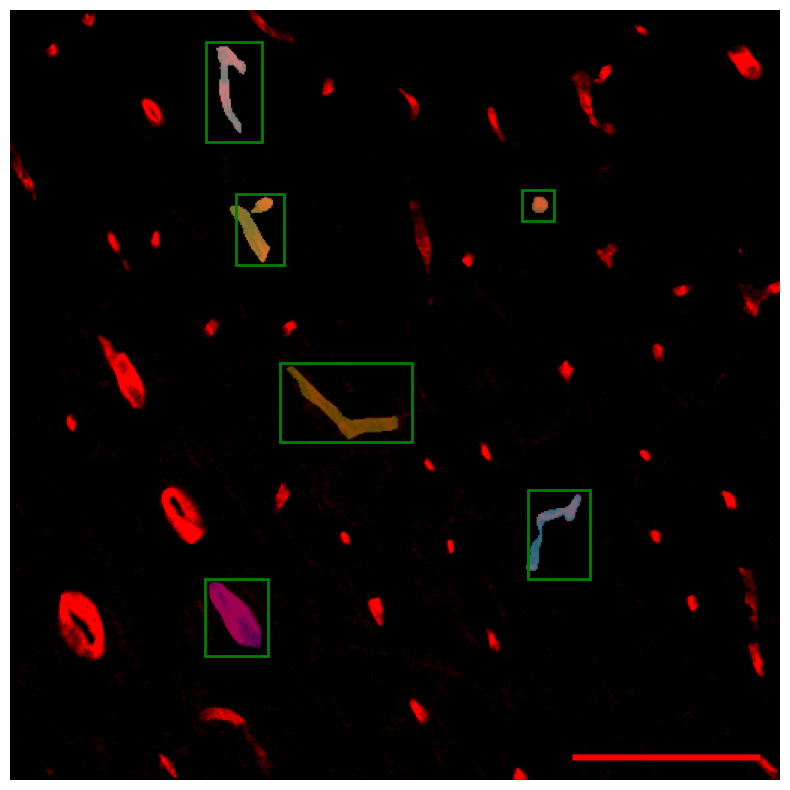

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()